# COMPAS PROJECT STAGE 2: Heterocyclic aromatic systems

## Summary

In this Jupyter notebook, we will demonstrate the application of the best regression model for correcting the calculated properties obtained using the GFN1-xTB method. The regression model, which was obtained through multi-linear regression analysis, provides a simple and interpretable approach for correcting the GFN1-xTB values based on the individual features (numbers of atoms of each type).

In [54]:
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem

from pathlib import Path
import json
import re

import numpy as np
import pandas as pd

from datetime import datetime
from tqdm import tqdm

TIMESPAM = datetime.now().strftime("%y%m%d_%H%M%S")

import mols2grid

import matplotlib.pyplot as plt
import seaborn as sns
from utils.func import calc_gap, calc_aea_aip
from utils.regression import prepare_model


# training different models and comparing them
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, ARDRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
# import standar scaler
from sklearn.preprocessing import StandardScaler
# import deepcopy
from copy import deepcopy

from utils import plotting

from utils.regression import Regressor, random_split, sabya_split
# show all pandas columns in vscode
pd.set_option('display.max_columns', None)

# set autoreload
%load_ext autoreload
%autoreload 2


DATA_FOLDER = Path('data')
FIGURE_FOLDER = Path('figures')
FIGURE_3 = FIGURE_FOLDER / "figure_3"
FIGURE_S2 = FIGURE_FOLDER / "figure_s2"

FIGURE_3.mkdir(parents=True, exist_ok=True)
FIGURE_S2.mkdir(parents=True, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading the Data

In [64]:
# read the compas-2x and compas-2D datasets
%time df_xtb = pd.read_csv('../compas-2x.csv',index_col=0)
%time df_dft = pd.read_csv('../compas-2D.csv',index_col=0)  

CPU times: total: 2.25 s
Wall time: 8.31 s
CPU times: total: 172 ms
Wall time: 721 ms


In [66]:
# merge the datasets
data = pd.merge(df_xtb.drop(columns=['formula', 'inchi', 'smiles', 
                                     'h', 'c', 'b', 's', 'o', 'n',
                                     'cyclobutadiene', 'pyrrole', 'borole',
                                     'furan', 'thiophene', 'dhdiborinine', '14diborinine',
                                     'pyrazine', 'pyridine', 'borinine', 'benzene'
                                     ]),
                df_dft, on=['name', 'charge'], suffixes=('_xtb', '_dft'))
data = data.query("charge == 0")
props = ['homo', 'lumo', 'gap', 'aip','aea','energy']

# Exploratory Data Visualization

The cells show the distribution of xTB- and DFT-calculated properties for the COMPAS-2D dataset. The scatter plots, colored by the density of points, show the distribution of the data points in the 2D space of the xTB- and DFT-calculated properties. The contour plots show the same distribution in continuous fashion to better visualize the density of points.

In [67]:
import matplotlib
colors = [
        [0, "#0082C1"], # 
        [0.3, "#A768A8"], # 
        [1, "#730B6E"], # 
            ]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
cmap.reversed()

In [68]:
# ETA ~ 3 min
from scipy.stats import gaussian_kde

# Calculate the point density
def get_kde(data, prop):
    x, y = data[f'{prop}_dft'],data[f'{prop}_xtb']
    xy = np.vstack([x,y])
    return gaussian_kde(xy)(xy)

for prop in props:
    data.loc[data.index,f"{prop}_z"] = get_kde(data, prop)

In [69]:
# make a 2x3 grid
fig, axs = plt.subplots(2,3,figsize=(5*2,5))
for i, prop in enumerate(props):
    ax = axs.flatten()[i]
    plotting.galaxy_plot(data, prop,
        ax = ax, name=FIGURE_S2 / f"galaxy-{prop}",
        alpha=0.5, c = data[f"{prop}_z"],
        limits=False, s=1, edgecolor="#FFFFFF", #cmap = cmap, 
        )
plt.tight_layout()

In [70]:
# ETA ~ 9 min
# make a 2x3 grid
fig, axs = plt.subplots(2,3,figsize=(5*2,5))
for i, prop in enumerate(props):
    ax = axs.flatten()[i]
    plotting.contour_plot(data, prop, tresh=None,
        ax = ax,
        name=FIGURE_3 / f"emcontour-{prop}"
        )
plt.tight_layout()

# Train the best model

In [71]:
scalers = [None]
atoms = ['h', 'c', 'b', 's', 'o', 'n']
props = ['homo', 'lumo', 'gap', 'aip', 'aea', 'energy']
targets = {prop:f"{prop}_dft" for prop in props}

targets = {prop:f"{prop}_dft" for prop in props}
features_sets = {"atoms":{prop:[f"{prop}_xtb"]+atoms for prop in props},
                }

models = [LinearRegression(),
        ]
model_names = ['LinearRegression', 
            ]

results = []
for scaler in scalers:
    trined_models = []
    metrics = []
    for skmode, name in zip(models, model_names):
        for prop, target in targets.items():
            for set, features in features_sets.items():
                model, r2, rmse, mae, pearsonr = prepare_model(deepcopy(skmode), data, target, features[prop], scaler)
                results.append([name, model, r2, rmse, mae, pearsonr, set, prop, str(scaler).split('(')[0]])
results = pd.DataFrame(results,columns=['name','model','r2','rmse','mae','pearson','set','prop', 'scaler'])

results.groupby(['name','set','prop']).mean(numeric_only=True).sort_values(['name','set','prop']).round(2).head(10)

r2  rmse   mae  pearson
name             set   prop                             
LinearRegression atoms aea     0.74  0.32  0.23     0.86
                       aip     0.84  0.22  0.14     0.91
                       energy  1.00  0.02  0.02     1.00
                       gap     0.89  0.23  0.16     0.94
                       homo    0.89  0.16  0.11     0.94
                       lumo    0.94  0.14  0.10     0.97

# Model Coefficients

In this section, we will present the coefficients and intercepts obtained from the multi-linear regression analysis for each property. 

In [72]:
# make a df_coef dataframe model.features, model.model.coef_
coeffs = []
intercepts = []
xtb = []
for i, row in results.iterrows():
    model = row['model']
    coeffs.append({feature:coef  for i, (feature, coef) in enumerate(zip(model.features, model.model.coef_)) if i !=0})
    xtb.append(model.model.coef_[0])
    intercepts.append(model.model.intercept_)
    
df_coef = pd.DataFrame(coeffs)

df_coef['xtb'] = xtb
df_coef['intercepts'] = intercepts
df_coef['name'] = results['name']
df_coef['set'] = results['set']
df_coef['r2'] = results['r2']
df_coef['rmse'] = results['rmse']
df_coef['mae'] = results['mae']
df_coef['pearson'] = results['pearson']
df_coef['prop'] = results['prop']

df_coef = df_coef[['prop','h', 'c', 'b', 's', 'o', 'n', 'xtb', 'intercepts','r2','rmse', 'mae']]
# df_coef = df_coef.sort_values(['prop'])[['prop','r2','rmse', 'mae']]
df_coef.round(4)

prop       h        c        b         s        o        n     xtb  \
0    homo  0.0124   0.0065  -0.0423   -0.0370   0.0258  -0.0253  1.2396   
1    lumo  0.0160  -0.0079  -0.0862   -0.0303   0.0238  -0.0093  1.0648   
2     gap  0.0263  -0.0245  -0.0358    0.0222   0.0190   0.0331  1.1815   
3     aip  0.0061   0.0088   0.0608    0.0824   0.0042   0.0538  1.3537   
4     aea  0.0504  -0.0103  -0.1113    0.0012   0.0469   0.0164  0.8820   
5  energy -0.2102 -36.3793 -23.6932 -395.1947 -71.4597 -52.1923  0.7880   

   intercepts      r2    rmse     mae  
0      6.2841  0.8929  0.1600  0.1086  
1      8.1821  0.9423  0.1410  0.0996  
2      3.4427  0.8852  0.2315  0.1592  
3    -10.3931  0.8363  0.2234  0.1438  
4      4.6421  0.7435  0.3172  0.2306  
5      0.1285  1.0000  0.0231  0.0183

# Visualizing the Model Performance

In this section, we will visualize the performance of the regression model for each property.

## Residuals

Index(['homo_xtb', 'h', 'c', 'b', 's', 'o', 'n'], dtype='object')
Index(['lumo_xtb', 'h', 'c', 'b', 's', 'o', 'n'], dtype='object')
Index(['gap_xtb', 'h', 'c', 'b', 's', 'o', 'n'], dtype='object')
Index(['aip_xtb', 'h', 'c', 'b', 's', 'o', 'n'], dtype='object')
Index(['aea_xtb', 'h', 'c', 'b', 's', 'o', 'n'], dtype='object')
Index(['energy_xtb', 'h', 'c', 'b', 's', 'o', 'n'], dtype='object')


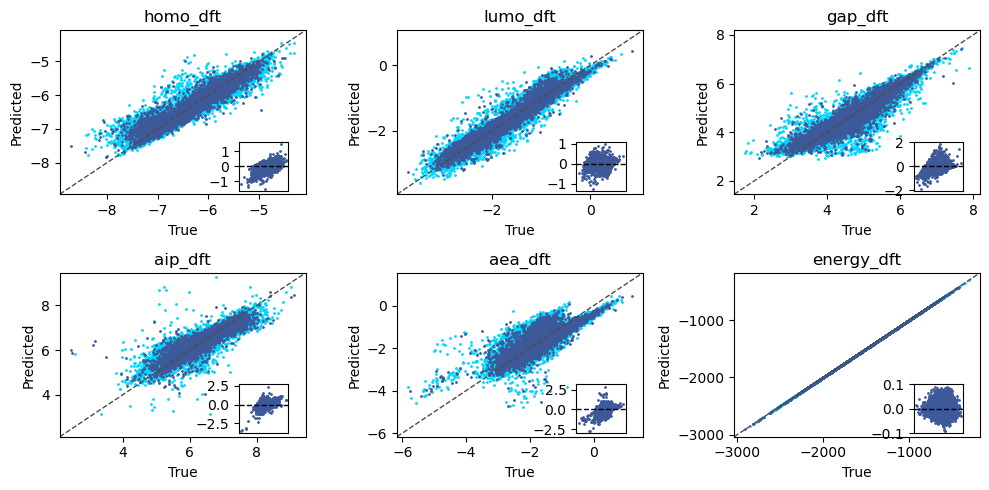

In [73]:
fig, axs = plt.subplots(2,3,figsize=(5*2,5))
for i, row in results.iterrows():
    prop = row['prop']
    model = row['model']
    _, ax, axins = plotting.plot_train_test_residual_inset(model,
     axs.flatten()[i],
    #  name=FIGURE_FOLDER / f"residuals-{prop}"
     )
plt.tight_layout()
    

## Distributions of the DFT and Predicted Values

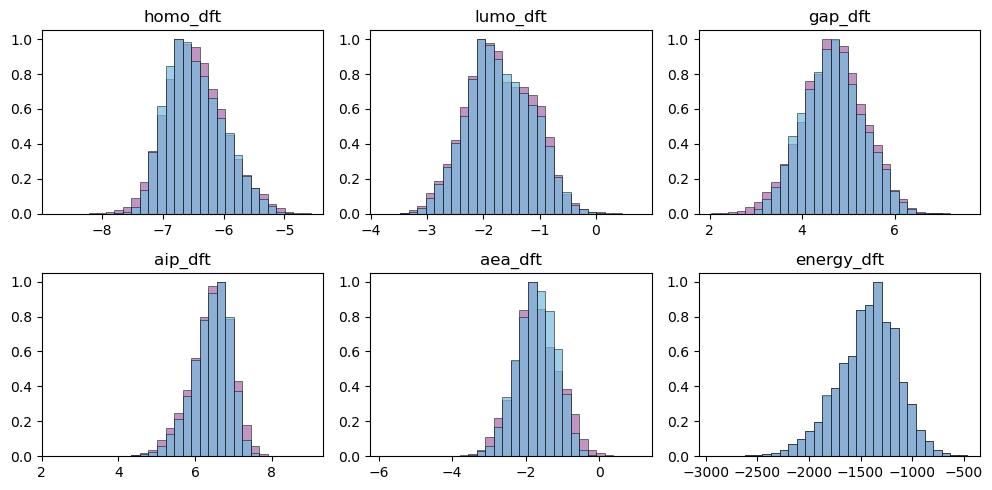

In [74]:
# plot normalized histogram of the predictions and the true values
# with the bins located at the same place for each model

fig, axs = plt.subplots(2,3,figsize=(5*2,5))

for i, row in results.iterrows():
    model = row['model']
    prop = row['prop']

    # get the bins from the y_test
    h_test,  bins = np.histogram(model.y_test, bins=30, density=True)
    # get the histogram of the predictions for the same bins
    h_pred, _ = np.histogram(model.predict(model.X_test), bins=bins, density=True)
    # normalize
    h_test = h_test / h_test.max()
    h_pred = h_pred / h_pred.max()
    # plot the histograms
    axs.flatten()[i].bar(bins[:-1], h_test, width=np.diff(bins), label='Calculated', color='#A768A8', alpha=0.7,  edgecolor='k', linewidth=0.5)
    axs.flatten()[i].bar(bins[:-1], h_pred, width=np.diff(bins), label='Corrected', color='#76BCDE', alpha=0.7,  edgecolor='k', linewidth=0.5)
    
    axs.flatten()[i].set_title(f'{model.target}')

    # figure to save
    fig, ax = plt.subplots(figsize=(4,4), dpi=300)
    ax.bar(bins[:-1], h_test, width=np.diff(bins), label='Calculated', color='#A768A8', alpha=0.6,  edgecolor='k', linewidth=0.5)
    ax.bar(bins[:-1], h_pred, width=np.diff(bins), label='Corrected', color='#76BCDE', alpha=0.6,  edgecolor='k', linewidth=0.5)
    # square plot
    ax.set_box_aspect(1)
    ax.legend()
    ax.set_title(f'{model.target}')
    # hide y ticks
    ax.set_yticks([])
    # save the figure
    fig.savefig(FIGURE_FOLDER / 'figure_4' / f'{model.target}_histogram.png', transparent=True)
    #svg
    fig.savefig(FIGURE_FOLDER / 'figure_4' / f'{model.target}_histogram.svg', transparent=True)
    plt.close(fig)
plt.tight_layout()
    

# Applying the Correction to the GFN1-xTB Data

In [75]:
# Applying the Correction to the GFN1-xTB Data
# -------------------------------------------

# load the GFN1-xTB data
df_xtb = pd.read_csv('../compas-2x.csv')

mapper = {
    'homo':'homo_xtb',
    'lumo':'lumo_xtb',
    'gap':'gap_xtb',
    'aip':'aip_xtb',
    'aea':'aea_xtb',
    'energy':'energy_xtb',
}

In [76]:
# apply the correction
df_xtb.rename(columns={k:v for k,v in mapper.items()}, inplace=True)
for i, row in results.iterrows():
    model = row['model']    
    # print(row['model'].target, model.features)
    corr = f"{row['model'].target.replace('dft','corr')}"
    print(model.target, model.features, corr)
    features = df_xtb.query('charge == 0')[model.features]
    predictions = model.predict(features)
    df_xtb[corr] = np.nan
    df_xtb.loc[features.index,corr] = predictions

# save the corrected_values to compas-2x.csv
df_xtb.rename(columns={v:k for k,v in mapper.items()}, inplace=True)

columns = [
# identifiers
'name',
'charge',
'formula', 
'inchi', 
'smiles',
# structural descriptors
'rings','aromatic_rings','atoms','heteroatoms','heterocycles','branch',
# substructures
'cyclobutadiene', 'pyrrole', 'borole', 'furan', 'thiophene', 'dhdiborinine', '14diborinine', 'pyrazine', 'pyridine', 'borinine','benzene',
# atoms
'h', 'c', 'b', 's', 'o', 'n',
# orbital energies
# 'occupancy', 
# 'orbital_energies',
'homo', 
'lumo', 
'homo-1', 
'lumo+1',
'gap', 
# molecular energies 
# 'electronic_energy',
'zero_point_energy',
'dispersion',
'energy',
'aip',
'aea', 
'dipole',
'homo_corr', 
'lumo_corr',
'gap_corr', 
'energy_corr',
'aip_corr', 
'aea_corr', 
]

df_xtb = df_xtb[columns]
df_xtb.to_csv('../compas-2x.csv')

homo_dft ['homo_xtb', 'h', 'c', 'b', 's', 'o', 'n'] homo_corr
lumo_dft ['lumo_xtb', 'h', 'c', 'b', 's', 'o', 'n'] lumo_corr
gap_dft ['gap_xtb', 'h', 'c', 'b', 's', 'o', 'n'] gap_corr
aip_dft ['aip_xtb', 'h', 'c', 'b', 's', 'o', 'n'] aip_corr
aea_dft ['aea_xtb', 'h', 'c', 'b', 's', 'o', 'n'] aea_corr
energy_dft ['energy_xtb', 'h', 'c', 'b', 's', 'o', 'n'] energy_corr


In [79]:
# read the compas-2x and compas-2D datasets
%time df_xtb = pd.read_csv('../compas-2x.csv', index_col=0)
%time df_dft = pd.read_csv('../compas-2D.csv', index_col=0)

CPU times: total: 2.17 s
Wall time: 8.81 s
CPU times: total: 78.1 ms
Wall time: 870 ms
